In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
import statsmodels
from statsmodels.tsa.stattools import adfuller
import time
import math 


plt.style.use('ggplot')

In [2]:
# read train data file 
df_train = pd.read_csv(r'data/ffd_train_split2018-01-01.csv').set_index('Date')
# read test data file
df_test = pd.read_csv(r'data/ffd_test_split2018-01-01_end2019-01-01.csv').set_index('Date')
# split date
split_date = df_test.index[0]
# concat df_train and df_test since we perform transformation on both set using the same clusters
df = pd.concat([df_train, df_test], axis=0)
df.drop(columns=['VXUS'], inplace=True)
display(df)

,RAY,QQQ,T10Y3M,CL1,HG1,GC1,XAG,VNQ,EURtoUSD,EEM,VIX
Date,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.24
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.19
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.22
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.11
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.26
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-25,-0.273546,0.169696,-0.312136,5.713054,36.372333,81.287335,2.418022,13.954414,0.568579,26.835077,36.07
2018-12-26,77.749107,10.253434,0.097014,9.804212,40.738189,81.136961,2.669372,16.728878,0.564725,27.620274,30.41
2018-12-27,61.960664,7.605217,0.065795,7.815269,35.815890,87.416785,2.786645,16.492451,0.572821,27.552075,29.96


In [3]:
#manually import all models and put those into a dictionary
model_dict = {}
#load model syntax
import pickle
#VIX
filename = r'model/temporal clusterVIX_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['VIX'] = [model,2,60] #[model,k,win_size]
#CL1
filename = r'model/temporal clusterCL1_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['CL1'] = [model,2,60] #[model,k,win_size]
#EEM
filename = r'model/temporal clusterEEM_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['EEM'] = [model,2,60] #[model,k,win_size]
#EURtoUSD
filename = r'model/temporal clusterEURtoUSD_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['EURtoUSD'] = [model,2,60] #[model,k,win_size]
#GC1
filename = r'model/temporal clusterGC1_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['GC1'] = [model,2,20] #[model,k,win_size]
#HG1
filename = r'model/temporal clusterHG1_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['HG1'] = [model,2,20] #[model,k,win_size]
#QQQ
filename = r'model/temporal clusterQQQ_k3_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['QQQ'] = [model,3,20] #[model,k,win_size]
#RAY
filename = r'model/temporal clusterRAY_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['RAY'] = [model,2,20] #[model,k,win_size]
#T10Y3M
filename = r'model/temporal clusterT10Y3M_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['T10Y3M'] = [model,2,20] #[model,k,win_size]
#VNQ
filename = r'model/temporal clusterVNQ_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['VNQ'] = [model,2,20] #[model,k,win_size]
#VXUS
filename = r'model/temporal clusterVXUS_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['VXUS'] = [model,2,60] #[model,k,win_size]
#XAG
filename = r'model/temporal clusterXAG_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['XAG'] = [model,2,20]  # [model,k,win_size]

In [4]:
def sliding_window(feature_series, win, step=1):
    
    # feature series start from the first valid index
    first_valid = feature_series.first_valid_index()
    feature = feature_series[first_valid:]
    
    # window construction
    df_feature = pd.DataFrame(columns= [i for i in range(win)])
    for i in range(0, len(feature) - win, step):
        index = feature.index[i + win-1]
        df_feature.loc[index] = feature.iloc[i: i + win].values
    
    # if the dataframe does not include the last date of the series, add it to make sure we always include newest data
    if (df_feature.index[-1] != feature.index[-1]):
        index = feature.index[-1]
        df_feature.loc[index] = feature.iloc[-(win):].values
    
    # normalize (minmax)
    df_feature = (df_feature - df_feature.min(1).values.reshape(-1, 1)) / (df_feature.max(1).values.reshape(-1, 1) - df_feature.min(1).values.reshape(-1, 1))
    return df_feature

In [5]:
# find the longest window
longest_win = max([model_dict[i][2] for i in model_dict.keys()])
# find the latest first valid
latest_valid = max([df[col].first_valid_index() for col in df])
# find start point of df
df_start_index = df.index.get_loc(latest_valid) + longest_win - 1
df_start_date = df.index[df_start_index]

In [6]:
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()
for col in df.columns:
    # find the start date of col
    col_win = model_dict[col][2]
    col_start_index = df_start_index - col_win + 1
    # create sliding window
    X = sliding_window(df.iloc[col_start_index:][col], col_win)
    X_fitted = model_dict[col][0].transform(X)
    df_transform = pd.DataFrame(X_fitted, index=X.index)
    # split into test and train set
    df_train_transform = df_transform.loc[:split_date].add_prefix(col+'_feature')
    df_test_transform = df_transform.loc[split_date:].add_prefix(col+'_feature')
    df_train_all = pd.concat([df_train_all, df_train_transform], axis=1)
    df_test_all = pd.concat([df_test_all, df_test_transform], axis=1)

D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings

In [24]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 10,
}

In [35]:
def Graph_cluster(df_feature, model, name):
    y_pred = model.predict(df_feature)
    fig, axs = plt.subplots(1, model.n_clusters, figsize=(10, 5))
    for yi in range(model.n_clusters): 
#         #row that subplot belongs
#         rw= math.floor(yi/col)
#         #col that subplot belongs
#         cl = (yi % col)
        axs[yi].plot(df_feature[y_pred == yi].sample(10).T, "k-", alpha=.2)
        axs[yi].plot(model.cluster_centers_[yi], "r-", linewidth=2.0)
        axs[yi].set_title(str(name)+" Template %d"% (yi + 1), font1)
        [temp.set_fontname('Times New Roman') for temp in axs[yi].get_xticklabels()]
        [temp.set_fontname('Times New Roman') for temp in axs[yi].get_yticklabels()]
    fig.savefig(str(name) + 'pattern.svg')
    fig.tight_layout()

D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7329 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 4901 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7029 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6984 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
D:\Anaconda\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7115 1-dimensional timeseries
  warnings

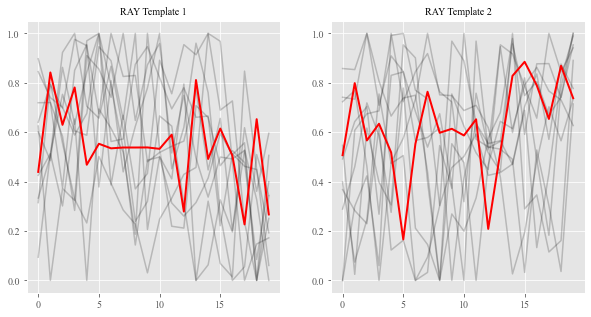

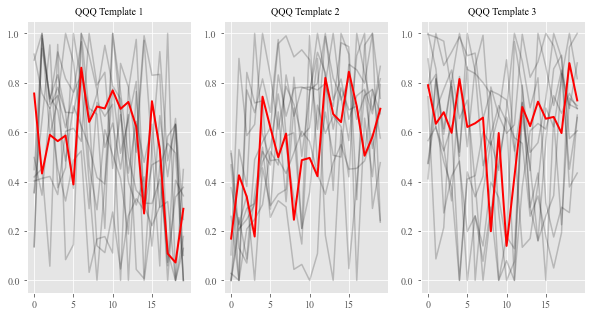

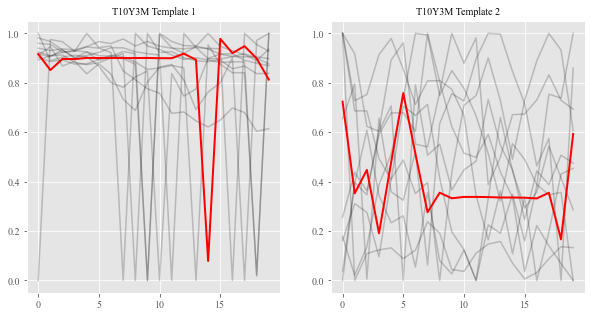

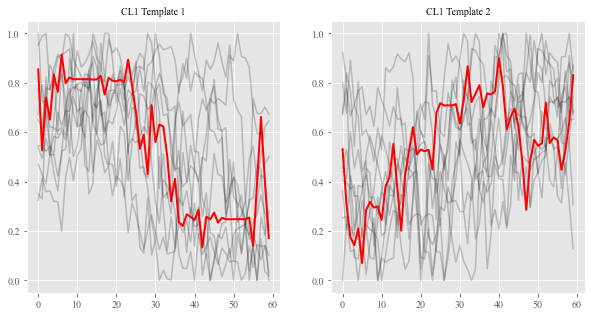

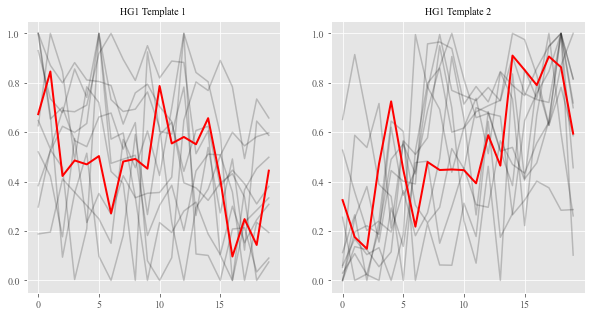

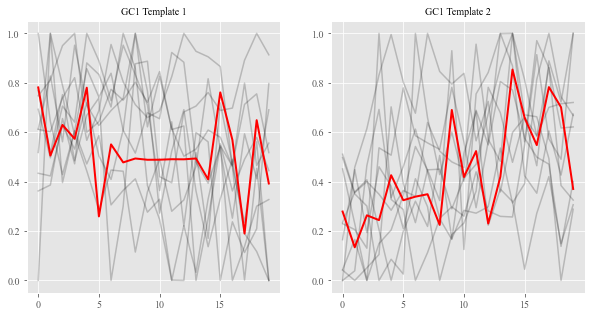

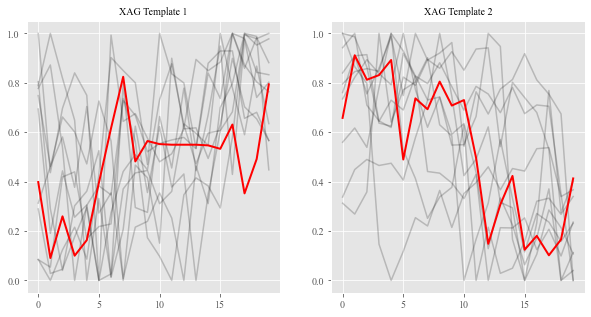

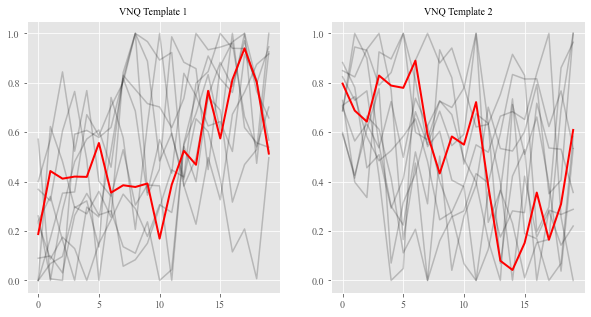

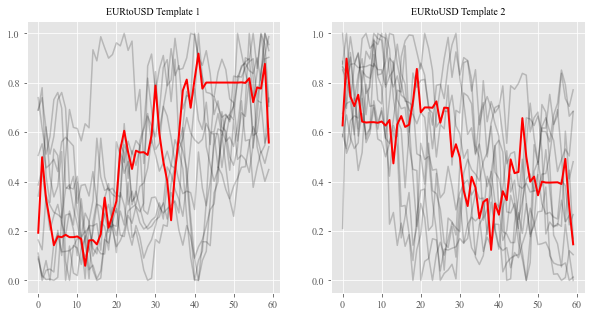

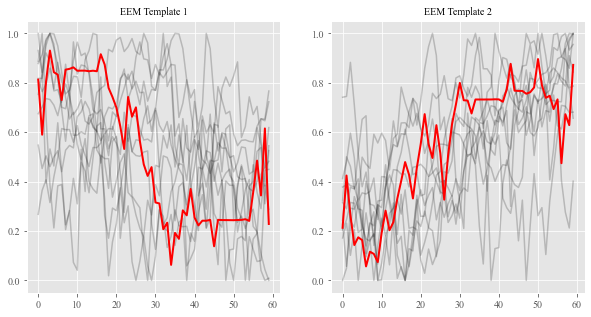

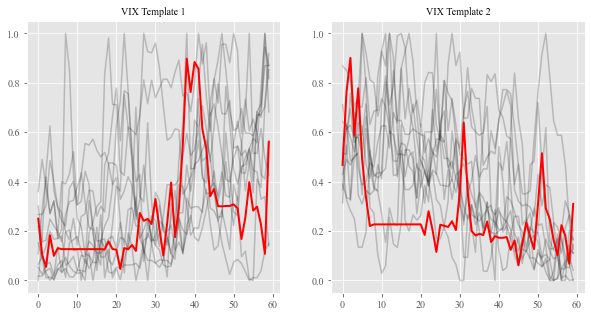

In [36]:
# graphing
for col in df:
    df_feature = sliding_window(df[col], model_dict[col][2])
    Graph_cluster(df_feature, model_dict[col][0], col)

In [9]:
# #PCA
# from sklearn.decomposition import PCA
# #StandardScaler()
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# pca = PCA(0.95)
# df_train_scaled=pd.DataFrame(scaler.fit_transform(df_train_all),index=df_train_all.index)
# df_test_scaled =pd.DataFrame(scaler.transform(df_test_all),index = df_test_all.index)

In [10]:
# df_train_pca

In [11]:
# df_train_pca = pd.DataFrame(pca.fit_transform(df_train_scaled),index=df_train_all.index)
# df_test_pca = pd.DataFrame(pca.transform(df_test_scaled),index = df_test_all.index)

In [12]:
# #PCA file
# filename = '/pca_tempfeature_train_split'+str(split_date)+'.csv'
# end_date = df_test_pca.tail(1).index[0]
# df_train_pca.to_csv(root+filename)
# filename = '/pca_tempfeature_test_split'+str(split_date)+'_end'+str(end_date)+'.csv'
# df_test_pca.to_csv(root+filename)

In [13]:
#non PCA file
filename = '/tempfeature_train_split'+str(split_date)+'.csv'
end_date = df_test_all.tail(1).index[0]
df_train_all.to_csv(root+filename)
filename = '/tempfeature_test_split'+str(split_date)+'_end'+str(end_date)+'.csv'
df_test_all.to_csv(root+filename)

NameError: name 'root' is not defined